In [345]:
import pandas as pd
import os
import numpy as np
import cv2
import json
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score,average_precision_score,precision_score,recall_score
import tqdm

In [264]:
#open manual annotated image from geojson (exported qupath image as geojason because paquo installation failed)
src = r'\\fatherserverdw\Q\research\images\skin_aging\hovernet_tile\hovernet_manual_validation'
manual = os.path.join(src,'manual_annotation')
predicted = os.path.join(src,'predicted_nuclei_contour')
raw_ims = os.path.join(src,'raw_image')

In [265]:
#open manual annotations with json.load
annotations = glob.glob(os.path.join(manual,'*.geojson'))
annotation = annotations[1]
with open(annotation) as f:
  features = json.load(f)["features"]

In [266]:
#create a list of manual contours
man_coordinates = [np.squeeze(_['geometry']['coordinates']) for _ in features]

In [267]:
manual_df = pd.DataFrame({'contour':man_coordinates})
manual_df

,contour
0,"[[368, 427], [368, 428], [367, 428], [366, 429..."
1,"[[242, 339], [241, 340], [239, 340], [238, 341..."
2,"[[168, 364], [167, 365], [166, 365], [166, 366..."
3,"[[322, 384], [321, 385], [320, 385], [319, 386..."
4,"[[387, 334], [387, 335], [386, 335], [386, 336..."
...,...
379,"[[230.0, 311.0], [230.0, 313.0], [233.0, 313.0..."
380,"[[370, 314], [370, 315], [369, 315], [369, 317..."
381,"[[959.0, 403.0], [959.0, 404.0], [957.0, 404.0..."
382,"[[543, 354], [543, 355], [542, 355], [542, 356..."


In [268]:
# def contour2centroid(c):
#     M = cv2.moments(c)
#     cX = int(M["m10"] / M["m00"])
#     cY = int(M["m01"] / M["m00"])
#     return np.array([cX,cY])

def contour2centroid(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

In [269]:
manual_df['centroid']=manual_df['contour'].apply(lambda row:contour2centroid(row))
manual_df

,contour,centroid
0,"[[368, 427], [368, 428], [367, 428], [366, 429...","(369.93939393939394, 438.969696969697)"
1,"[[242, 339], [241, 340], [239, 340], [238, 341...","(242.16666666666666, 346.2142857142857)"
2,"[[168, 364], [167, 365], [166, 365], [166, 366...","(172.02564102564102, 371.64102564102564)"
3,"[[322, 384], [321, 385], [320, 385], [319, 386...","(325.8695652173913, 392.4130434782609)"
4,"[[387, 334], [387, 335], [386, 335], [386, 336...","(390.0408163265306, 342.7959183673469)"
...,...,...
379,"[[230.0, 311.0], [230.0, 313.0], [233.0, 313.0...","(248.45238095238096, 313.3095238095238)"
380,"[[370, 314], [370, 315], [369, 315], [369, 317...","(390.7014925373134, 322.2089552238806)"
381,"[[959.0, 403.0], [959.0, 404.0], [957.0, 404.0...","(961.75, 413.4935897435897)"
382,"[[543, 354], [543, 355], [542, 355], [542, 356...","(547.936170212766, 360.7659574468085)"


In [270]:
#open prediction
pd_annotations = glob.glob(os.path.join(predicted,'*.json'))
#open tile11
pd_annotation = pd_annotations[0]
with open(pd_annotation) as pd_f:
  #bbox, centroid, contour
  pd_features = json.load(pd_f)["nuc"]

In [271]:
#create a list of predicted contours
pd_contours=[]
pd_centroids = []
for key in pd_features:
    temp = pd_features.get(key)
    pd_contours.append(np.array(temp.get('contour')))
    pd_centroids.append(np.round(temp.get('centroid'),0).astype('int'))

In [272]:
predicted_df = pd.DataFrame({'contour':pd_contours,'centroid':pd_centroids})
predicted_df

,contour,centroid
0,"[[667, 300], [666, 301], [666, 302], [667, 301...","[690, 305]"
1,"[[615, 306], [614, 307], [611, 307], [610, 308...","[612, 315]"
2,"[[517, 309], [516, 310], [513, 310], [513, 311...","[522, 318]"
3,"[[675, 310], [674, 311], [673, 311], [672, 312...","[679, 318]"
4,"[[503, 311], [501, 313], [499, 313], [497, 315...","[502, 318]"
...,...,...
342,"[[310, 921], [310, 922], [309, 923], [307, 923...","[310, 927]"
343,"[[698, 930], [698, 931], [697, 932], [698, 933...","[704, 938]"
344,"[[206, 942], [205, 943], [204, 943], [203, 944...","[206, 945]"
345,"[[331, 951], [327, 955], [327, 956], [326, 957...","[331, 958]"


In [273]:
#get size of origianl image
raw = glob.glob(os.path.join(raw_ims,'*.tif'))
raw_img = cv2.imread(raw[0])
dim = raw_img.shape
image_size = (dim[0],dim[1])

In [274]:
#Link ground truth to predicted nuclei
from sklearn.neighbors import NearestNeighbors

#create a list of manual centroids, and a list of predicted centroids
manual_centroid= np.array(manual_df['centroid'].values.tolist())
predicted_centroid= np.array(predicted_df['centroid'].values.tolist())
nbrs = NearestNeighbors(n_neighbors=1, metric='euclidean').fit(predicted_centroid) #build model
distances, indices = nbrs.kneighbors(manual_centroid) #apply model
indices=np.squeeze(indices)

In [275]:
indices

array([104,  22,  33,  57,  20,  25,  47,  31,  68,  75,  79,  50,  40,
        38,  69,  70,  97, 122, 127,  90, 105,  73, 146, 132, 108, 131,
        43,  23,  55,  51,  87, 110, 123, 116, 157, 152, 145, 209, 190,
       192, 223, 111,  72, 203, 147, 166, 178, 185, 226, 182, 169,  44,
        16,  14,  24,  17,  12,  52,  35,  45,  56,  44,  76,  88,  83,
        67,  93,  42,  64, 113,  91,  78, 113,  61,  95, 124, 138, 148,
       170, 158, 187, 184, 201, 215, 211, 218, 231, 230, 218, 234, 238,
       252, 240, 241, 251, 242, 245, 247, 248, 250, 254, 216, 191, 207,
       188, 160, 159, 129, 101,  84,  94,  46, 191,  71,  49,  80, 103,
        58,  81,  74, 100, 118,  99,  92, 112,  54,  30,  34,  63,  65,
        59,  39,  28,  37,  27, 139, 161, 179, 193, 221, 227, 220, 196,
       204, 195, 198, 243, 246, 264, 264, 277, 277, 296, 312, 313, 321,
       332, 340, 340, 341, 323, 330, 315, 314, 327, 294, 295, 290, 307,
       302, 273, 278, 262, 266, 281, 268, 274, 289, 288, 276, 28

In [276]:
#false positive indexes
# (but we also need to add the ones with low iou,we don't know if it's a false positive or false negative
unpaired_predicted_idx_1 = [_ for _ in np.array(predicted_df.index) if _ not in np.unique(indices)]


In [277]:
predicted_df2 = predicted_df.iloc[indices]

In [278]:
linked_df = manual_df
linked_df['pred_contour'] =predicted_df2.contour.reset_index(drop=True)
linked_df['pred_centroid'] =predicted_df2.centroid.reset_index(drop=True)
linked_df['pred_idx'] = predicted_df2.index


In [279]:
linked_df

,contour,centroid,pred_contour,pred_centroid,pred_idx
0,"[[368, 427], [368, 428], [367, 428], [366, 429...","(369.93939393939394, 438.969696969697)","[[369, 428], [367, 430], [367, 431], [366, 432...","[370, 439]",104
1,"[[242, 339], [241, 340], [239, 340], [238, 341...","(242.16666666666666, 346.2142857142857)","[[242, 338], [241, 339], [239, 339], [238, 340...","[242, 346]",22
2,"[[168, 364], [167, 365], [166, 365], [166, 366...","(172.02564102564102, 371.64102564102564)","[[172, 363], [171, 364], [169, 364], [168, 365...","[173, 372]",33
3,"[[322, 384], [321, 385], [320, 385], [319, 386...","(325.8695652173913, 392.4130434782609)","[[321, 384], [320, 385], [319, 385], [316, 388...","[325, 392]",57
4,"[[387, 334], [387, 335], [386, 335], [386, 336...","(390.0408163265306, 342.7959183673469)","[[391, 334], [390, 335], [388, 335], [387, 336...","[390, 343]",20
...,...,...,...,...,...
379,"[[230.0, 311.0], [230.0, 313.0], [233.0, 313.0...","(248.45238095238096, 313.3095238095238)","[[242, 338], [241, 339], [239, 339], [238, 340...","[242, 346]",22
380,"[[370, 314], [370, 315], [369, 315], [369, 317...","(390.7014925373134, 322.2089552238806)","[[360, 314], [359, 315], [357, 315], [356, 316...","[377, 320]",6
381,"[[959.0, 403.0], [959.0, 404.0], [957.0, 404.0...","(961.75, 413.4935897435897)","[[957, 405], [956, 406], [954, 406], [952, 408...","[960, 413]",77
382,"[[543, 354], [543, 355], [542, 355], [542, 356...","(547.936170212766, 360.7659574468085)","[[545, 354], [544, 355], [542, 355], [540, 357...","[549, 361]",26


In [281]:
scores=[]
paired_pred_idx = []
#label is the pixel value (color) from [1,384]
for index, row in linked_df.iterrows():
    groundtruth_mask = np.zeros(image_size)
    predicted_mask = np.zeros(image_size)
    groundtruth_mask = cv2.fillPoly(groundtruth_mask, pts=[np.array(row['contour']).astype(np.int32)],  color=1)
    predicted_mask = cv2.fillPoly(predicted_mask, pts=[np.array(row['pred_contour']).astype(np.int32)],  color=1)
    score = jaccard_score(groundtruth_mask,predicted_mask, average="micro")
    scores.append(score)

    #ashley added,if doesn't work, delete
    if(score >= 0.5):
        #add to paired nuclei idx
        paired_pred_idx.append(row['pred_idx'])




In [282]:
len(paired_pred_idx)

306

In [283]:
unpaired_predicted_idx_2 =  set(indices) - set(paired_pred_idx)

In [284]:
len(unpaired_predicted_idx_2)

24

In [285]:
len(unpaired_predicted_idx_1)

17

In [286]:
unpaired_pred_contour = []

#iterate through idx list1
for idx in unpaired_predicted_idx_1:
    unpaired_pred_contour.append(predicted_df.iloc[idx].contour)

for idx in unpaired_predicted_idx_2:
    unpaired_pred_contour.append(predicted_df.iloc[idx].contour)

In [287]:
linked_df['jaccard_score']=scores
linked_df #Look into why some cells have low score when centroids actually match

,contour,centroid,pred_contour,pred_centroid,pred_idx,jaccard_score
0,"[[368, 427], [368, 428], [367, 428], [366, 429...","(369.93939393939394, 438.969696969697)","[[369, 428], [367, 430], [367, 431], [366, 432...","[370, 439]",104,0.776923
1,"[[242, 339], [241, 340], [239, 340], [238, 341...","(242.16666666666666, 346.2142857142857)","[[242, 338], [241, 339], [239, 339], [238, 340...","[242, 346]",22,0.890152
2,"[[168, 364], [167, 365], [166, 365], [166, 366...","(172.02564102564102, 371.64102564102564)","[[172, 363], [171, 364], [169, 364], [168, 365...","[173, 372]",33,0.854305
3,"[[322, 384], [321, 385], [320, 385], [319, 386...","(325.8695652173913, 392.4130434782609)","[[321, 384], [320, 385], [319, 385], [316, 388...","[325, 392]",57,0.815873
4,"[[387, 334], [387, 335], [386, 335], [386, 336...","(390.0408163265306, 342.7959183673469)","[[391, 334], [390, 335], [388, 335], [387, 336...","[390, 343]",20,0.821429
...,...,...,...,...,...,...
379,"[[230.0, 311.0], [230.0, 313.0], [233.0, 313.0...","(248.45238095238096, 313.3095238095238)","[[242, 338], [241, 339], [239, 339], [238, 340...","[242, 346]",22,0.000000
380,"[[370, 314], [370, 315], [369, 315], [369, 317...","(390.7014925373134, 322.2089552238806)","[[360, 314], [359, 315], [357, 315], [356, 316...","[377, 320]",6,0.541069
381,"[[959.0, 403.0], [959.0, 404.0], [957.0, 404.0...","(961.75, 413.4935897435897)","[[957, 405], [956, 406], [954, 406], [952, 408...","[960, 413]",77,0.730627
382,"[[543, 354], [543, 355], [542, 355], [542, 356...","(547.936170212766, 360.7659574468085)","[[545, 354], [544, 355], [542, 355], [540, 357...","[549, 361]",26,0.890977


(array([52.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  2.,  1.,  0.,  0.,  0.,  0.,  1.,  2.,  1.,  1.,  2.,  2.,
         1.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,  2.,  0.,  2.,  1.,
         0.,  2.,  2.,  3.,  1.,  1.,  1.,  3.,  2.,  1.,  5.,  4.,  3.,
         6.,  3.,  6.,  7.,  5.,  2.,  4., 11.,  8.,  4.,  5.,  7.,  7.,
         5.,  6., 12., 11., 11., 12., 14., 10.,  8., 11., 12.,  8., 10.,
         9., 11., 15.,  7., 10., 10.,  6.,  6.,  3.]),
 array([0.        , 0.0090678 , 0.01813559, 0.02720339, 0.03627119,
        0.04533898, 0.05440678, 0.06347458, 0.07254237, 0.08161017,
        0.09067797, 0.09974576, 0.10881356, 0.11788136, 0.12694915,
        0.13601695, 0.14508475, 0.15415254, 0.16322034, 0.17228814,
        0.18135593, 0.19042373, 0.19949153, 0.20855932, 0.21762712,
        0.22669492, 0.23576271, 0.24483051, 0.25389831, 0.2629661 ,
        0.2720339 , 0.2811

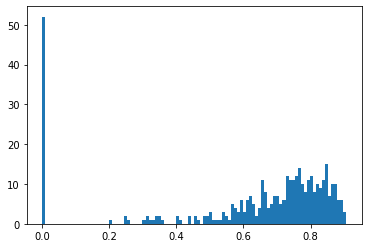

In [288]:
plt.hist(linked_df['jaccard_score'],100) #groundtruth has roughly 37 more nuclei 384 vs 347

In [289]:
np.mean(linked_df['jaccard_score'])

0.6198674819195928

In [290]:
from scipy.optimize import linear_sum_assignment

def get_fast_aji_plus(true, pred):
    """AJI+, an AJI version with maximal unique pairing to obtain overall intersecion.
    Every prediction instance is paired with at most 1 GT instance (1 to 1) mapping, unlike AJI
    where a prediction instance can be paired against many GT instances (1 to many).
    Remaining unpaired GT and Prediction instances will be added to the overall union.
    The 1 to 1 mapping prevents AJI's over-penalisation from happening.

    Fast computation requires instance IDs are in contiguous orderding i.e [1, 2, 3, 4]
    not [2, 3, 6, 10]. Please call `remap_label` before hand and `by_size` flag has no
    effect on the result.

    """
    true = np.copy(true)  # ? do we need this
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    true_masks = [
        None,
    ]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [
        None,
    ]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_inter = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )
    pairwise_union = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )

    # caching pairwise
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background

            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            pairwise_inter[true_id - 1, pred_id - 1] = inter
            pairwise_union[true_id - 1, pred_id - 1] = total - inter
    #
    pairwise_iou = pairwise_inter / (pairwise_union + 1.0e-6)
    #### Munkres pairing to find maximal unique pairing
    paired_true, paired_pred = linear_sum_assignment(-pairwise_iou)
    ### extract the paired cost and remove invalid pair
    paired_iou = pairwise_iou[paired_true, paired_pred]
    # now select all those paired with iou != 0.0 i.e have intersection
    paired_true = paired_true[paired_iou > 0.0]
    paired_pred = paired_pred[paired_iou > 0.0]
    paired_inter = pairwise_inter[paired_true, paired_pred]
    paired_union = pairwise_union[paired_true, paired_pred]
    paired_true = list(paired_true + 1)  # index to instance ID
    paired_pred = list(paired_pred + 1)
    overall_inter = paired_inter.sum()
    overall_union = paired_union.sum()


    # add all unpaired GT and Prediction into the union
    unpaired_true = np.array(
        [idx for idx in true_id_list[1:] if idx not in paired_true]
    )
    unpaired_pred = np.array(
        [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    )
    for true_id in unpaired_true:
        overall_union += true_masks[true_id].sum()
    for pred_id in unpaired_pred:
        overall_union += pred_masks[pred_id].sum()
    #
    aji_score = overall_inter / overall_union
    return aji_score


In [ ]:
#test, compute metrics for paried nucleus
#add the score for each pair tp dataframe

#----metrics for each nuclei-----
#dice_1
dice1 = []
# prediction score
precision = []
recall=[]

#average precision score is for the whole image
#pq
paired_true=0
unpaired_true=0
paired_iou = []
#threshold for iou
match_iou = 0.5

#aji
paired_inter= []
paired_union = []
#masks
unpaired_true_masks = []
paired_pred_masks = []
unpaired_pred_masks =[]


for index, row in linked_df.iterrows():
    groundtruth_mask = np.zeros(image_size)
    predicted_mask = np.zeros(image_size)
    groundtruth_mask = cv2.fillPoly(groundtruth_mask, pts=[np.array(row['contour']).astype(np.int32)],  color=1)
    predicted_mask = cv2.fillPoly(predicted_mask, pts=[np.array(row['pred_contour']).astype(np.int32)],  color=1)

    inter1 = groundtruth_mask * predicted_mask
    denom = groundtruth_mask + predicted_mask
    dice = 2.0 * np.sum(inter1) / np.sum((denom+1.0e-6))
    dice1.append(dice)

    p = precision_score(groundtruth_mask,predicted_mask, average="micro")
    precision.append(p)

    r = recall_score(groundtruth_mask,predicted_mask, average="micro")
    recall.append(r)

    iou = jaccard_score(groundtruth_mask,predicted_mask, average="micro")
    if(iou >= 0.5):#different thresholds give different results
        total = ( groundtruth_mask + predicted_mask).sum()
        inter = ( groundtruth_mask * predicted_mask).sum()
        paired_inter.append(inter)
        paired_union.append(total-inter)
        paired_pred_masks.append(predicted_mask)

    else:
        unpaired_true_masks.append(groundtruth_mask)


In [348]:
#add scores to dataframe
linked_df['dice1']=dice1
linked_df['precision']=precision
linked_df['recall'] = recall

In [349]:
linked_df

,contour,centroid,pred_contour,pred_centroid,pred_idx,jaccard_score,dice1,precision,recall
0,"[[368, 427], [368, 428], [367, 428], [366, 429...","(369.93939393939394, 438.969696969697)","[[369, 428], [367, 430], [367, 431], [366, 432...","[370, 439]",104,0.776923,0.872570,1.000000,0.776923
1,"[[242, 339], [241, 340], [239, 340], [238, 341...","(242.16666666666666, 346.2142857142857)","[[242, 338], [241, 339], [239, 339], [238, 340...","[242, 346]",22,0.890152,0.940000,0.955285,0.928854
2,"[[168, 364], [167, 365], [166, 365], [166, 366...","(172.02564102564102, 371.64102564102564)","[[172, 363], [171, 364], [169, 364], [168, 365...","[173, 372]",33,0.854305,0.919786,0.966292,0.880546
3,"[[322, 384], [321, 385], [320, 385], [319, 386...","(325.8695652173913, 392.4130434782609)","[[321, 384], [320, 385], [319, 385], [316, 388...","[325, 392]",57,0.815873,0.897033,0.955390,0.848185
4,"[[387, 334], [387, 335], [386, 335], [386, 336...","(390.0408163265306, 342.7959183673469)","[[391, 334], [390, 335], [388, 335], [387, 336...","[390, 343]",20,0.821429,0.900489,0.992806,0.826347
...,...,...,...,...,...,...,...,...,...
379,"[[230.0, 311.0], [230.0, 313.0], [233.0, 313.0...","(248.45238095238096, 313.3095238095238)","[[242, 338], [241, 339], [239, 339], [238, 340...","[242, 346]",22,0.000000,0.000000,0.000000,0.000000
380,"[[370, 314], [370, 315], [369, 315], [369, 317...","(390.7014925373134, 322.2089552238806)","[[360, 314], [359, 315], [357, 315], [356, 316...","[377, 320]",6,0.541069,0.701606,0.585331,0.877378
381,"[[959.0, 403.0], [959.0, 404.0], [957.0, 404.0...","(961.75, 413.4935897435897)","[[957, 405], [956, 406], [954, 406], [952, 408...","[960, 413]",77,0.730627,0.843450,0.987531,0.737430
382,"[[543, 354], [543, 355], [542, 355], [542, 356...","(547.936170212766, 360.7659574468085)","[[545, 354], [544, 355], [542, 355], [540, 357...","[549, 361]",26,0.890977,0.940476,0.987500,0.901141


In [299]:

#Panoptic Quality (not finished, this is for the whole image)
#tp = paired_true
#fp = len(predicted_df)-len(np.unique(indices))
#fn = unpaired_true
    # get the F1-score i.e DQ
#dq = tp / (tp + 0.5 * fp + 0.5 * fn)
    # get the SQ, no paired has 0 iou so not impact
#sq = sum(paired_iou) / (tp + 1.0e-6)

#Panoptic Quality and aji is for the whole image
#pq = dq * sq

#print(dq,sq,pq)

#aji
overall_inter = sum(paired_inter)
overall_union = sum(paired_union)

In [318]:

#TODO: add unpaired to overall union
#add unpaired true to overall union
for up_true in unpaired_true_masks:
    overall_union += ( up_true * 1).sum() #?does this work??

In [320]:

#add unpaired predicted to overall union
for up_pred in unpaired_pred_contour:
    predicted_mask = np.zeros(image_size)
    predicted_mask = cv2.fillPoly(predicted_mask, pts=[np.array(up_pred).astype(np.int32)],  color=1)
    overall_union+= (predicted_mask * 1).sum()

In [322]:

#aji score, this is an overall score
aji_score = overall_inter / overall_union

In [ ]:
np.mean(linked_df['jaccard_score'])

In [ ]:
def get_fast_pq(true, pred, match_iou=0.5):
    """`match_iou` is the IoU threshold level to determine the pairing between
    GT instances `p` and prediction instances `g`. `p` and `g` is a pair
    if IoU > `match_iou`. However, pair of `p` and `g` must be unique
    (1 prediction instance to 1 GT instance mapping).

    If `match_iou` < 0.5, Munkres assignment (solving minimum weight matching
    in bipartite graphs) is caculated to find the maximal amount of unique pairing.

    If `match_iou` >= 0.5, all IoU(p,g) > 0.5 pairing is proven to be unique and
    the number of pairs is also maximal.

    Returns:
        [dq, sq, pq]: measurement statistic

        [paired_true, paired_pred, unpaired_true, unpaired_pred]:
                      pairing information to perform measurement

    """
    assert match_iou >= 0.0, "Cant' be negative"

    true = np.copy(true)
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    true_masks = [
        None,
    ]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [
        None,
    ]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_iou = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )

    # caching pairwise iou
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            iou = inter / (total - inter)
            pairwise_iou[true_id - 1, pred_id - 1] = iou
    #
    if match_iou >= 0.5:
        paired_iou = pairwise_iou[pairwise_iou > match_iou]
        pairwise_iou[pairwise_iou <= match_iou] = 0.0
        paired_true, paired_pred = np.nonzero(pairwise_iou)
        paired_iou = pairwise_iou[paired_true, paired_pred]
        paired_true += 1  # index is instance id - 1
        paired_pred += 1  # hence return back to original
    else:  # * Exhaustive maximal unique pairing
        #### Munkres pairing with scipy library
        # the algorithm return (row indices, matched column indices)
        # if there is multiple same cost in a row, index of first occurence
        # is return, thus the unique pairing is ensure
        # inverse pair to get high IoU as minimum
        paired_true, paired_pred = linear_sum_assignment(-pairwise_iou)
        ### extract the paired cost and remove invalid pair
        paired_iou = pairwise_iou[paired_true, paired_pred]

        # now select those above threshold level
        # paired with iou = 0.0 i.e no intersection => FP or FN
        paired_true = list(paired_true[paired_iou > match_iou] + 1)
        paired_pred = list(paired_pred[paired_iou > match_iou] + 1)
        paired_iou = paired_iou[paired_iou > match_iou]

    # get the actual FP and FN
    unpaired_true = [idx for idx in true_id_list[1:] if idx not in paired_true]
    unpaired_pred = [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    # print(paired_iou.shape, paired_true.shape, len(unpaired_true), len(unpaired_pred))

    #
    tp = len(paired_true)
    fp = len(unpaired_pred)
    fn = len(unpaired_true)
    # get the F1-score i.e DQ
    dq = tp / (tp + 0.5 * fp + 0.5 * fn)
    # get the SQ, no paired has 0 iou so not impact
    sq = paired_iou.sum() / (tp + 1.0e-6)

    return [dq, sq, dq * sq], [paired_true, paired_pred, unpaired_true, unpaired_pred]

In [ ]:
def get_fast_aji_plus(true, pred):
    """AJI+, an AJI version with maximal unique pairing to obtain overall intersecion.
    Every prediction instance is paired with at most 1 GT instance (1 to 1) mapping, unlike AJI
    where a prediction instance can be paired against many GT instances (1 to many).
    Remaining unpaired GT and Prediction instances will be added to the overall union.
    The 1 to 1 mapping prevents AJI's over-penalisation from happening.

    Fast computation requires instance IDs are in contiguous orderding i.e [1, 2, 3, 4]
    not [2, 3, 6, 10]. Please call `remap_label` before hand and `by_size` flag has no
    effect on the result.

    """
    true = np.copy(true)  # ? do we need this
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    true_masks = [
        None,
    ]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [
        None,
    ]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_inter = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )
    pairwise_union = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )

    # caching pairwise
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background

            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            pairwise_inter[true_id - 1, pred_id - 1] = inter
            pairwise_union[true_id - 1, pred_id - 1] = total - inter
    #
    pairwise_iou = pairwise_inter / (pairwise_union + 1.0e-6)
    #### Munkres pairing to find maximal unique pairing
    paired_true, paired_pred = linear_sum_assignment(-pairwise_iou)
    ### extract the paired cost and remove invalid pair
    paired_iou = pairwise_iou[paired_true, paired_pred]
    # now select all those paired with iou != 0.0 i.e have intersection
    paired_true = paired_true[paired_iou > 0.0]
    paired_pred = paired_pred[paired_iou > 0.0]
    paired_inter = pairwise_inter[paired_true, paired_pred]
    paired_union = pairwise_union[paired_true, paired_pred]
    paired_true = list(paired_true + 1)  # index to instance ID
    paired_pred = list(paired_pred + 1)
    overall_inter = paired_inter.sum()
    overall_union = paired_union.sum()


    # add all unpaired GT and Prediction into the union
    unpaired_true = np.array(
        [idx for idx in true_id_list[1:] if idx not in paired_true]
    )
    unpaired_pred = np.array(
        [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    )
    for true_id in unpaired_true:
        overall_union += true_masks[true_id].sum()
    for pred_id in unpaired_pred:
        overall_union += pred_masks[pred_id].sum()
    #
    aji_score = overall_inter / overall_union
    return aji_score


In [98]:
#test, compute metrics for paried nucleus
#add the score for each pair tp dataframe

#dice_1
dice1 = []

#pq
paired_true=0
unpaired_true=0
paired_iou = []
#threshold for iou
match_iou = 0.5

#aji
paired_inter= []
paired_union = []


for index, row in linked_df.iterrows():
    groundtruth_mask = np.zeros(image_size)
    predicted_mask = np.zeros(image_size)
    groundtruth_mask = cv2.fillPoly(groundtruth_mask, pts=[np.array(row['contour']).astype(np.int32)],  color=1)
    predicted_mask = cv2.fillPoly(predicted_mask, pts=[np.array(row['pred_contour']).astype(np.int32)],  color=1)

    #inter1 = groundtruth_mask * predicted_mask
    #denom = groundtruth_mask + predicted_mask
    #dice = 2.0 * np.sum(inter1) / np.sum((denom+1.0e-6))
    #dice1.append(dice)


    iou = jaccard_score(groundtruth_mask,predicted_mask, average="micro")
    if(iou>0):
        total = ( groundtruth_mask + predicted_mask).sum()
        inter = ( groundtruth_mask * predicted_mask).sum()
        paired_inter.append(inter)
        paired_union.append(total-inter)


    #iou is the same  as jaccard_score

    #if(iou >= match_iou):
        #paired_iou.append(iou)
        #paired_true = paired_true+1
    #extract unpaired nucleus
    #else:
        #unpaired_true  = unpaired_true+1






#Panoptic Quality
tp = paired_true
fp = len(predicted_df)-len(np.unique(indices))
fn = unpaired_true
    # get the F1-score i.e DQ
dq = tp / (tp + 0.5 * fp + 0.5 * fn)
    # get the SQ, no paired has 0 iou so not impact
sq = sum(paired_iou) / (tp + 1.0e-6)

#Panoptic Quality and aji is for the whole image
pq = dq * sq

print(dq,sq,pq)

#aji
overall_inter = paired_inter.sum()
overall_union = paired_union.sum()

#add unpaired to overall union

0.8656294200848657 0.7460312648556475


306

78

In [78]:
#add metrics to dataframe
#calculate aji
linked_df['dice1']=dice1
linked_df


,contour,centroid,pred_contour,pred_centroid,jaccard_score,iou,dice1
0,"[[368, 427], [368, 428], [367, 428], [366, 429...","(369.93939393939394, 438.969696969697)","[[369, 428], [367, 430], [367, 431], [366, 432...","[370, 439]",0.776923,0.776923,0.872570
1,"[[242, 339], [241, 340], [239, 340], [238, 341...","(242.16666666666666, 346.2142857142857)","[[242, 338], [241, 339], [239, 339], [238, 340...","[242, 346]",0.890152,0.890152,0.940000
2,"[[168, 364], [167, 365], [166, 365], [166, 366...","(172.02564102564102, 371.64102564102564)","[[172, 363], [171, 364], [169, 364], [168, 365...","[173, 372]",0.854305,0.854305,0.919786
3,"[[322, 384], [321, 385], [320, 385], [319, 386...","(325.8695652173913, 392.4130434782609)","[[321, 384], [320, 385], [319, 385], [316, 388...","[325, 392]",0.815873,0.815873,0.897033
4,"[[387, 334], [387, 335], [386, 335], [386, 336...","(390.0408163265306, 342.7959183673469)","[[391, 334], [390, 335], [388, 335], [387, 336...","[390, 343]",0.821429,0.821429,0.900489
...,...,...,...,...,...,...,...
379,"[[230.0, 311.0], [230.0, 313.0], [233.0, 313.0...","(248.45238095238096, 313.3095238095238)","[[242, 338], [241, 339], [239, 339], [238, 340...","[242, 346]",0.000000,0.000000,0.000000
380,"[[370, 314], [370, 315], [369, 315], [369, 317...","(390.7014925373134, 322.2089552238806)","[[360, 314], [359, 315], [357, 315], [356, 316...","[377, 320]",0.541069,0.541069,0.701606
381,"[[959.0, 403.0], [959.0, 404.0], [957.0, 404.0...","(961.75, 413.4935897435897)","[[957, 405], [956, 406], [954, 406], [952, 408...","[960, 413]",0.730627,0.730627,0.843450
382,"[[543, 354], [543, 355], [542, 355], [542, 356...","(547.936170212766, 360.7659574468085)","[[545, 354], [544, 355], [542, 355], [540, 357...","[549, 361]",0.890977,0.890977,0.940476


In [52]:
#ashley:try out the metrics, inputs are binary masks of groundtruth and predicted nucleus
#their functions also convert the true and pred inputs to binary masks.
# I think they just take in an integer array of an image

#question: do you compute these scores for each nuclei with its pair and take an average, or do you do it on the overall image
#i did it on the overall image
dc1= get_dice_1(groundtruth_mask,predicted_mask)
dc2 = get_fast_dice_2(groundtruth_mask,predicted_mask) #this equals dc1

dq, sq, pq = get_fast_pq(groundtruth_mask,predicted_mask)[0]


#TODO: need to modify the function because the function is expecting labeled masks
aji = get_fast_aji_plus(groundtruth_mask,predicted_mask)

#theyalso have a pair-coordinates function

In [46]:
#don't know what this does
paired_true, paired_pred, unpaired_true, unpaired_pred = get_fast_pq(groundtruth_mask,predicted_mask)[1]